## Libraries & Loading

In [86]:
!pip install lightgbm
!pip install xgboost
!pip install imbalanced-learn

In [118]:
# Loading libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import calendar
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import plot_importance
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.offsetbox import AnchoredText
import math
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
import statsmodels.api as sm
import scipy.stats as stats

In [119]:
# Defining file paths & reading CSVs - separate file for DF containing ic data
csv_path = '/home/n8309116/swan/IFN704 Project/Saved_DFs/'
hourly_df = pd.read_csv(csv_path + 'preprocessed_hourly_data2.csv')
hourly_ic_df = pd.read_csv(csv_path + 'preprocessed_hourly_ic_data2.csv')

In [120]:
print(hourly_df.dtypes)

time               object
dem_poe10         float64
dem_poe50         float64
dem_poe90         float64
dem_act           float64
rrp               float64
power_qld         float64
bris_temp         float64
bris_wind         float64
bris_dp           float64
public_holiday      int64
dow                 int64
doy                 int64
month               int64
hour                int64
dtype: object


In [121]:
print(hourly_ic_df.dtypes)

time               object
net_ic_flow       float64
dem_poe10         float64
dem_poe50         float64
dem_poe90         float64
dem_act           float64
rrp               float64
power_qld         float64
bris_temp         float64
bris_wind         float64
bris_dp           float64
public_holiday      int64
dow                 int64
doy                 int64
month               int64
hour                int64
dtype: object


In [122]:
# Reusing function for lag features
def create_lag_features(df, lags=2):
  y = hourly_df.loc[:, "dem_act"]
  for lag in range(lags):
    df[f"lag{lag + 1}"] = y.shift(lag + 1)
  return df

Classifying demand exceedances of POE10, I propose a logit model:

$$
\log \left( \frac{P}{1 - P} \right) = \text{bris\_temp} + \text{net\_ic\_flow} + \text{demand}_{t-1} + \text{hour} + \text{month} + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)
$$

In [123]:
# Checking exceedance distribution
print((hourly_ic_df['dem_act'] > hourly_ic_df['dem_poe10']).sum())
print((hourly_ic_df['dem_act'] <= hourly_ic_df['dem_poe10']).sum())

406
11191


In [124]:
hourly_ic_df = create_lag_features(hourly_ic_df, lags=1)

In [125]:
# DF for GLM
logit_df = hourly_ic_df[['net_ic_flow', 'hour', 'month', 'bris_temp', 'lag1']].copy()
logit_df['target'] = (hourly_ic_df['dem_act'] > hourly_ic_df['dem_poe10']).astype(int)
logit_df.head()

,net_ic_flow,hour,month,bris_temp,lag1,target
0,-5688.50113,10,3,27.90,NaN,0
1,-5653.10117,11,3,28.45,5837.5,0
2,-5967.20118,12,3,29.30,5659.5,0
3,-10919.30117,13,3,29.70,5561.5,0
4,-13638.00108,14,3,29.20,5501.0,0


In [126]:
print(logit_df['target'].value_counts())

target
0    11191
1      406
Name: count, dtype: int64


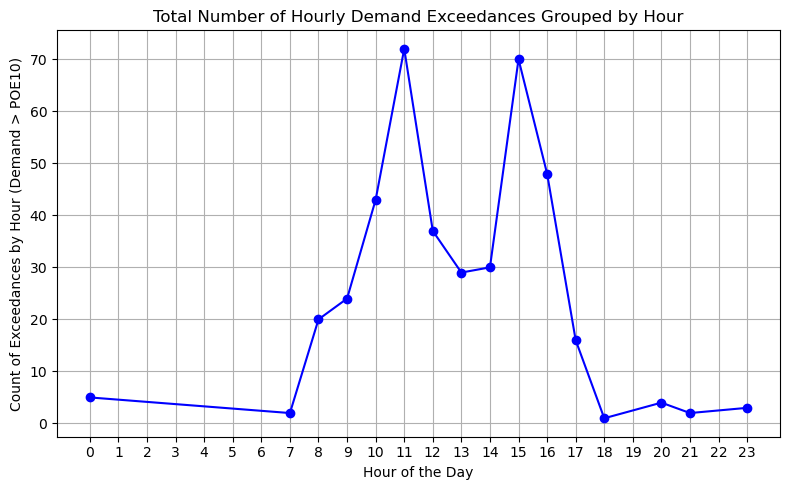

In [127]:
# Checking distribution by hour
exceedances_by_hour = logit_df[logit_df['target'] == 1].groupby('hour').size()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(exceedances_by_hour.index, exceedances_by_hour.values, marker='o', linestyle='-', color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Exceedances by Hour (Demand > POE10)')
plt.title('Total Number of Hourly Demand Exceedances Grouped by Hour')
plt.grid(True)
plt.xticks(range(24))  # Ensure x-axis has labels for every hour (0-23)
plt.tight_layout()
plt.show()

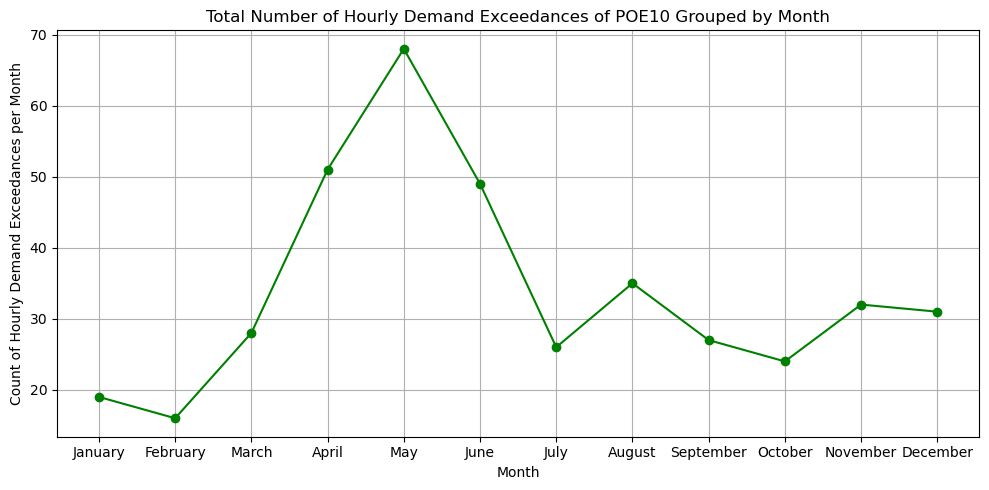

In [128]:
# Checking distribution by month
exceedances_by_month = logit_df[logit_df['target'] == 1].groupby('month').size()

# Creating list
month_names = [calendar.month_name[i] for i in exceedances_by_month.index]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(month_names, exceedances_by_month.values, marker='o', linestyle='-', color='green')
plt.xlabel('Month')
plt.ylabel('Count of Hourly Demand Exceedances per Month')
plt.title('Total Number of Hourly Demand Exceedances of POE10 Grouped by Month')
plt.grid(True)
plt.tight_layout()
plt.show()

In [129]:
# Removing NAN row (1st row)
logit_df = logit_df.iloc[1:].reset_index(drop=True)
logit_df.head(5)

,net_ic_flow,hour,month,bris_temp,lag1,target
0,-5653.10117,11,3,28.45,5837.5,0
1,-5967.20118,12,3,29.30,5659.5,0
2,-10919.30117,13,3,29.70,5561.5,0
3,-13638.00108,14,3,29.20,5501.0,0
4,-15231.30146,15,3,28.60,5490.0,0


In [130]:
print(logit_df.dtypes)

net_ic_flow    float64
hour             int64
month            int64
bris_temp      float64
lag1           float64
target           int64
dtype: object


## Pre-processing for Logit

- Standardising numeric variables
- One-hot encoding categorical variables (hour & month)
- Oversampling training set to achieve 50/50 class balance

In [131]:
# Copying DF for cleanliness & one hot encoding (OHE)
logit_df_encoded = logit_df.copy()
logit_df_encoded['hour'] = logit_df_encoded['hour'].astype('category')
logit_df_encoded['month'] = logit_df_encoded['month'].astype('category')
logit_df_encoded = pd.get_dummies(logit_df, columns=['hour', 'month'], drop_first=True)

# Splitting data
X = logit_df_encoded.drop(columns=['target'])
y = logit_df_encoded['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42) # will use same random_state for LGB model

# Oversampling
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Standardising numeric vars
numeric_columns = ['net_ic_flow', 'bris_temp', 'lag1']
scaler = StandardScaler()
X_train_resampled_standardized = X_train_resampled.copy()
X_test_standardized = X_test.copy()
X_train_resampled_standardized[numeric_columns] = scaler.fit_transform(X_train_resampled[numeric_columns])
X_test_standardized[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Constant term added
X_train_resampled_with_const = sm.add_constant(X_train_resampled_standardized)
X_test_with_const = sm.add_constant(X_test_standardized)

# Convert boolean columns to integers
X_train_resampled_with_const = X_train_resampled_with_const.astype(int)
X_test_with_const = X_test_with_const.astype(int)

In [132]:
# Fitting model
logit_model = sm.Logit(y_train_resampled, X_train_resampled_with_const)
result = logit_model.fit(maxiter=250)

# Printing summary and predicting for 0.5 threshold
print(result.summary())
y_pred = result.predict(X_test_with_const)
y_pred_binary = [1 if x >= 0.5 else 0 for x in y_pred]

# Evaluating
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

         Current function value: 0.414887
         Iterations: 250
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12588
Model:                          Logit   Df Residuals:                    12550
Method:                           MLE   Df Model:                           37
Date:                Tue, 05 Nov 2024   Pseudo R-squ.:                  0.3482
Time:                        12:28:37   Log-Likelihood:                -5222.6
converged:                      False   LL-Null:                       -8012.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.3634      0.175    -13.497      0.000      -2.707      -2.020
net_ic_flow     0.3897      0.042      9.371      0.000      

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- As expected, model heavily overpredicts the minority class due to oversampling (precision for positive class is 0.1)
- Net IC flow significant coefficient - OR is 1.477 (exp(coeff)) meaning 48% increased odds of an hour exceeding POE10 demand for 1 std inc in net_ic_flow
- This reflects perhaps there is unpredictable volatility/factors influencing flows that cannot be modelled with this data (e.g., intrastate effects in NSW)
- This justifies using the actual hour flow not the lag one, i.e. wouldn't be available if building a predictive model, goal is explaining factors

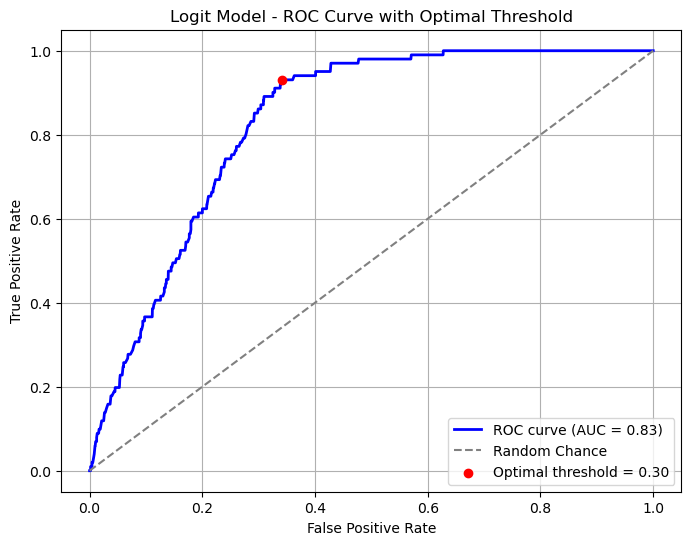

Optimal threshold: 0.30


In [133]:
# Plotting ROC curve with inflection point (furthest from diagonal 0.5 line)
y_pred_proba = result.predict(X_test_with_const)

# Obtaining necessary values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculating Youden's J statistic - seeks to balance TPR + TNR, maximise recall for positive class
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Chance')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal threshold = {optimal_threshold:.2f}', zorder=5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logit Model - ROC Curve with Optimal Threshold')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print(f"Optimal threshold: {optimal_threshold:.2f}")

In [134]:
# Convert predictions to binary with desired threshold of 0.3
y_pred_binary = [1 if x >= 0.3 else 0 for x in y_pred]

# Evaluating
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))


Confusion Matrix:
[[1848  950]
 [   8   93]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.66      0.79      2798
           1       0.09      0.92      0.16       101

    accuracy                           0.67      2899
   macro avg       0.54      0.79      0.48      2899
weighted avg       0.96      0.67      0.77      2899



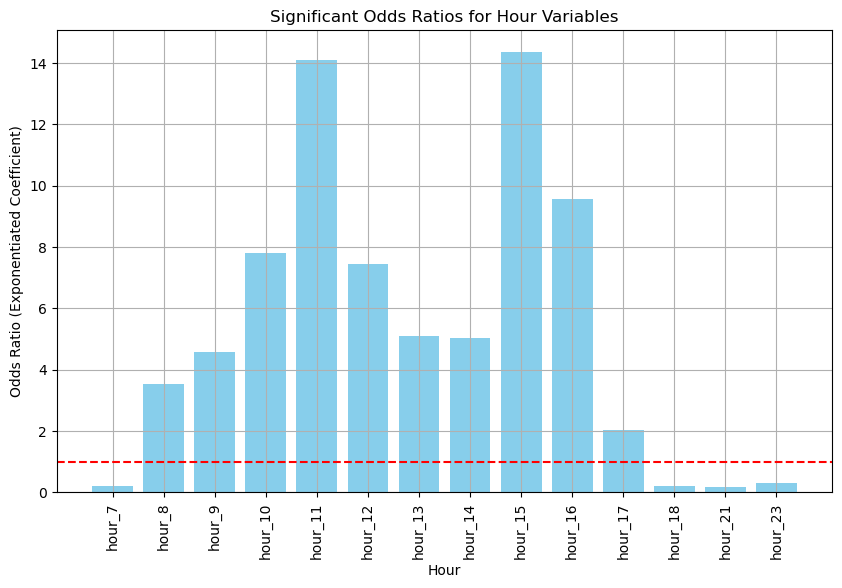

In [135]:
# Plotting significant hour ORs
hour_coeffs = result.params.filter(like='hour')
hour_pvals = result.pvalues.filter(like='hour')
significant_hours = hour_pvals[hour_pvals < 0.05].index
odds_ratios_hours = np.exp(hour_coeffs[significant_hours])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(significant_hours, odds_ratios_hours, color='skyblue')
plt.axhline(y=1, color='red', linestyle='--')  # Dashed line at 1
plt.xlabel('Hour')
plt.ylabel('Odds Ratio (Exponentiated Coefficient)')
plt.title('Significant Odds Ratios for Hour Variables')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

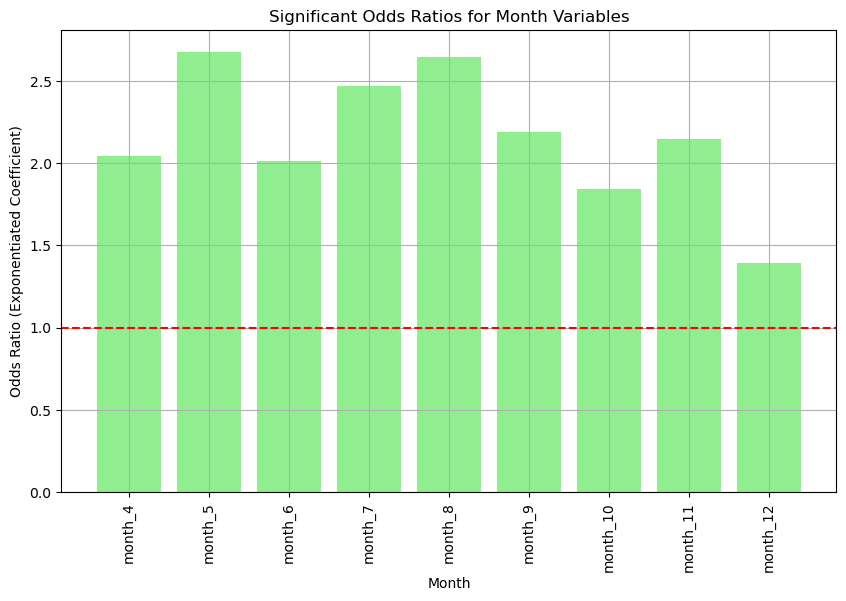

In [136]:
# Plotting significant month ORs
month_coeffs = result.params.filter(like='month')
month_pvals = result.pvalues.filter(like='month')
significant_months = month_pvals[month_pvals < 0.05].index
odds_ratios_months = np.exp(month_coeffs[significant_months])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(significant_months, odds_ratios_months, color='lightgreen')
plt.axhline(y=1, color='red', linestyle='--')  # Dashed line at 1
plt.xlabel('Month')
plt.ylabel('Odds Ratio (Exponentiated Coefficient)')
plt.title('Significant Odds Ratios for Month Variables')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Checking Normality of Errors

In [137]:
# Predicted probabilities
predicted_probs = result.predict(X_test_with_const)
# Residuals: observed - predicted
pearson_residuals = (y_test - predicted_probs) / np.sqrt(predicted_probs * (1 - predicted_probs))

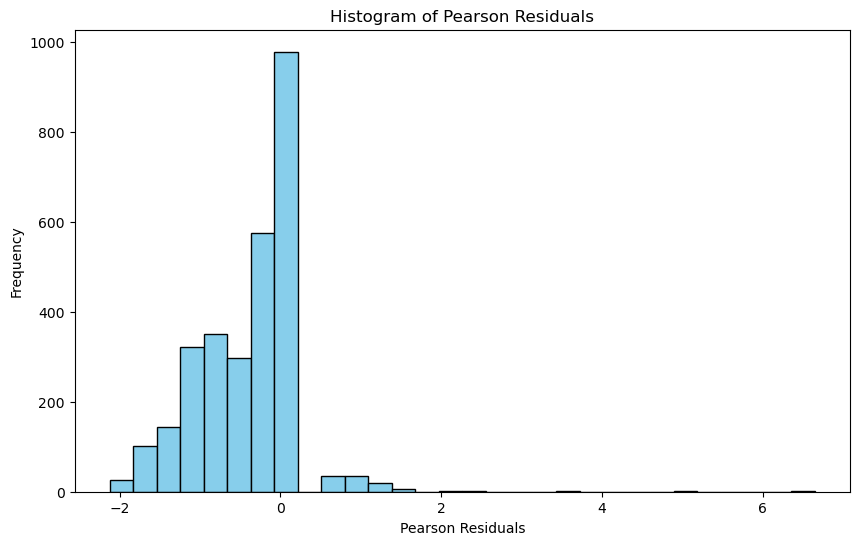

In [138]:
# Histogram
plt.figure(figsize=(10, 6))
plt.hist(pearson_residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Pearson Residuals")
plt.xlabel("Pearson Residuals")
plt.ylabel("Frequency")
plt.show()

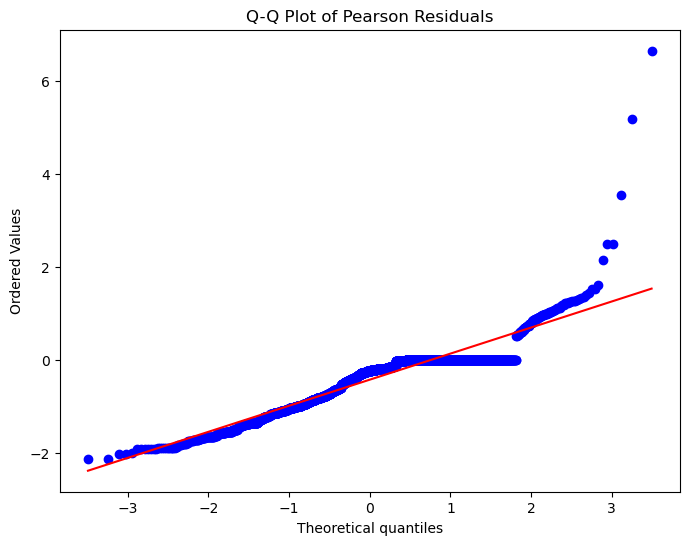

In [139]:
# QQ Plot
plt.figure(figsize=(8, 6))
stats.probplot(pearson_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Pearson Residuals")
plt.show()

In [140]:
# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(pearson_residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

Shapiro-Wilk Test: W=0.8761164535462728, p-value=3.381476558860939e-43


## Observations

- Clear deviation from normality confirmed by histogram, QQ plot and Shapiro-Wilk test
- Many hour and month coefficients are highly significant, consistent with the plots earlier
- Net IC flow is significant and positive, while the other numeric variables are non-significant

## LightGBM Classifier

In [141]:
# Splitting X & y
X, y = logit_df.drop(columns=['target']), logit_df['target']

In [142]:
# Splitting data into 1) train/test, and 2) splitting training into train/val for tuning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [143]:
# from sklearn.metrics import roc_auc_score
# import lightgbm as lgbm
# from lightgbm import early_stopping, log_evaluation

# # Small grid search
# param_grid = {
#     'num_leaves': [15, 30, 50],
#     'max_depth': [5, 10],
#     'min_child_samples': [20, 50],
#     'colsample_bytree': [0.6, 0.8],
#     'n_estimators': [50, 100]  # Reduced values for faster training
# }

# # Generating HP combinations
# param_list = list(ParameterGrid(param_grid))

# # Initialising variables
# best_score = -np.inf
# best_params = None

# # Loop through
# for params in param_list:
#     # LightGBM model with current hyperparameters
#     model = lgbm.LGBMClassifier(
#         learning_rate=0.01,
#         **params,
#         is_unbalance=True
#     )
    
#     # Training model
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_valid, y_valid)],
#         eval_metric='auc',
#         callbacks=[log_evaluation(0)]  # Disable training output for faster execution
#     )
    
#     # Predicting
#     y_pred = model.predict_proba(X_valid)[:, 1]
    
#     # Calculate AUC
#     auc = roc_auc_score(y_valid, y_pred)
    
#     # Update best score and parameters if current model is better
#     if auc > best_score:
#         best_score = auc
#         best_params = params.copy()
#         best_model = model

# # Printing optimal results
# print("Best hyperparameters:", best_params)
# print(f"Best validation AUC: {best_score:.4f}")

Note the above code block is commented out to suppress the output and tidy the notebook. The values defined below are those found by the grid search.

In [144]:
best_params = {'colsample_bytree': 0.8, 'max_depth': 5, 'min_child_samples': 50, 'n_estimators': 100, 'num_leaves': 30}

In [145]:
# Re-combining training and validation sets for re-training
X_train_final = np.concatenate((X_train, X_valid), axis=0)
y_train_final = np.concatenate((y_train, y_valid), axis=0)

# Oversampling
oversampler = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train_final_resampled, y_train_final_resampled = oversampler.fit_resample(X_train_final, y_train_final)

# Initialising LGBM model
model = lgb.LGBMClassifier(
    learning_rate=0.01,
    **best_params,
    is_unbalance=True,
    verbose=-1 # Suppress extensive output
)

In [146]:
# Training model on resampled set
lgb_model = model.fit(X_train_final_resampled, y_train_final_resampled, feature_name=list(X.columns))

# Evaluating
y_pred = model.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[2062  736]
 [  20   81]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      2798
           1       0.10      0.80      0.18       101

    accuracy                           0.74      2899
   macro avg       0.54      0.77      0.51      2899
weighted avg       0.96      0.74      0.82      2899



Observe biggest difference in LGBM v Logit is in recall for each class - LGBM much better at minority class, despite both being oversampled 50/50 split in training.

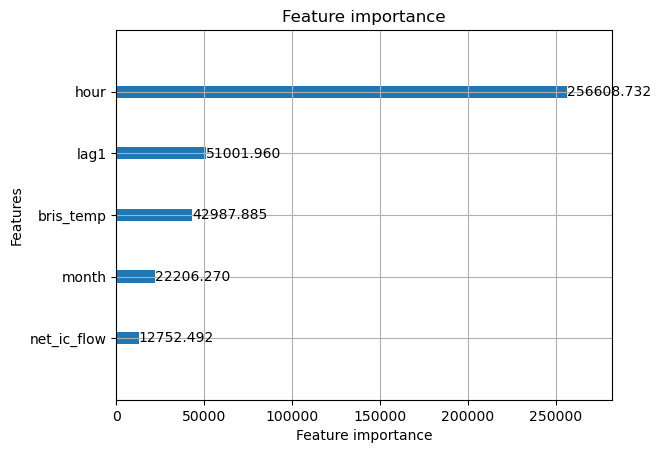

In [147]:
# LGB importance - accuracy improvement = 'gain'
lgb.plot_importance(lgb_model, importance_type='gain')
plt.show()

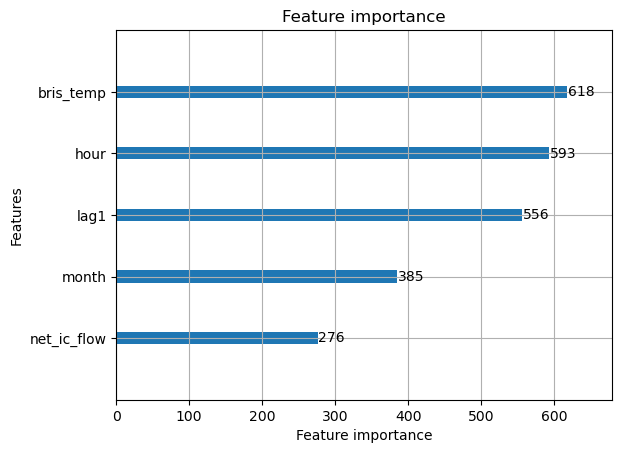

In [148]:
# LGB importance - split counts
lgb.plot_importance(lgb_model)
plt.show()